In [5]:
# define the RBM

import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden):
        # Initialize the number of visible and hidden units
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # Initialize weights with normally distributed random values, and biases with zeros
        self.weights = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    def _sigmoid(self, x):
        # Sigmoid activation function used for calculating probabilities
        return 1 / (1 + np.exp(-x))

    def train(self, data, num_epochs=100, initial_learning_rate=0.1, decay_rate=0.1):
        num_samples = data.shape[0]  # Number of training samples
        losses = []  # List to keep track of loss per epoch

        for epoch in range(num_epochs):
            # Decay learning rate as training progresses
            learning_rate = initial_learning_rate * np.exp(-decay_rate * epoch)

            # Positive phase - calculate the probabilities of the hidden units given the visible units
            hidden_prob = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)  # Sample from the calculated probabilities

            # Negative phase - reconstruct the visible units from the sampled hidden states
            visible_recon_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            visible_recon_state = self._sample(visible_recon_prob)  # Sample from the reconstructed probabilities
            hidden_recon_prob = self._sigmoid(np.dot(visible_recon_state, self.weights) + self.hidden_bias)

            # Calculate reconstruction error
            loss = np.mean((data - visible_recon_state) ** 2)
            losses.append(loss)  # Append loss for the epoch to the list

            # Update weights using Contrastive Divergence (CD)
            positive_associations = np.dot(data.T, hidden_prob)  # Positive phase associations
            negative_associations = np.dot(visible_recon_state.T, hidden_recon_prob)  # Negative phase associations
            self.weights += learning_rate * (positive_associations - negative_associations) / num_samples
            self.visible_bias += learning_rate * (np.sum(data - visible_recon_state, axis=0)) / num_samples
            self.hidden_bias += learning_rate * (np.sum(hidden_prob - hidden_recon_prob, axis=0)) / num_samples

        return losses

    def _sample(self, prob):
        # Sample binary states based on probabilities (stochastic binary units)
        return (np.random.random(size=prob.shape) < prob).astype(np.float32)
    
    def generate_sequence(self, initial_state, num_steps):
        # Generate a sequence of visible states by iteratively passing through hidden and visible layers
        state = initial_state
        sequence = []

        for step in range(num_steps):
            # Compute hidden units given the visible state
            hidden_prob = self._sigmoid(np.dot(state, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)

            # Compute visible units given the hidden state
            visible_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            state = self._sample(visible_prob)

            sequence.append(state)

        return np.array(sequence)
    
    def free_energy(self, v):

    # Compute the free energy of the visible units.
    # 'v' is the visible units vector.
    
        hidden_term = np.sum(np.log(1 + np.exp(self.hidden_bias + np.dot(v, self.weights))), axis=1)
        return -np.dot(v, self.visible_bias) - hidden_term
    
    def to_spin(self, prob):
        # Convert probabilities to binary spin states (-1 or 1)
        return np.where(np.random.random(size=prob.shape) < prob, 1, -1)

    def _sample_hidden(self, visible):
        # Compute the hidden states given the visible states
        hidden_activations = np.dot(visible, self.weights) + self.hidden_bias
        hidden_prob = self._sigmoid(hidden_activations)
        return self.to_spin(hidden_prob)

    def _sample_visible(self, hidden):
        # Compute the visible states given the hidden states
        visible_activations = np.dot(hidden, self.weights.T) + self.visible_bias
        visible_prob = self._sigmoid(visible_activations)
        return self.to_spin(visible_prob)


# Training

Fix a temperature, generate configurations at this temperature. Don't need to feed in temperature as label for rbm training since RBM is an unsupervised learning method, but for a conditional RBM could feed in the temperature label

# Training 'Type V' RBM

In [6]:
import numpy as np
rbm_data = np.load('rbm_data2.npy')
all_data = np.concatenate(rbm_data)
print(all_data.shape[1])

100


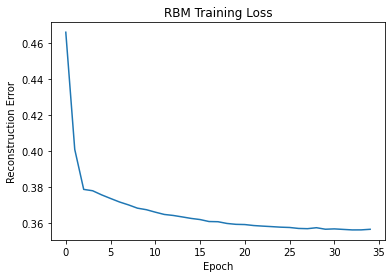

In [7]:
# Load the RBM data from a numpy binary file
# The data should be a 2D numpy array where each row is a flattened 2D spin lattice
rbm_data = np.load('rbm_data2.npy')

# Concatenate all configurations into one dataset
# This step is necessary if rbm_data is a list of arrays rather than a single 2D array
# If rbm_data is already a 2D array, this line can be omitted
all_data = np.concatenate(rbm_data)

# Number of spins should match the flattened 2D lattice size
# This is the number of visible units for the RBM

num_visible = all_data.shape[1]

num_hidden = 100  # The number of hidden units, a hyperparameter that you can tune

# Instantiate the RBM with the specified number of visible and hidden units
rbm = RBM(num_visible=num_visible, num_hidden=num_hidden)

# Train the RBM on the dataset for 35 epochs with an initial learning rate of 0.1
# The function returns the reconstruction errors for each epoch
losses = rbm.train(all_data, num_epochs=35, initial_learning_rate=0.1)

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Plot the reconstruction errors as a function of the epoch number
plt.plot(losses)
plt.title('RBM Training Loss')  # Add a title to the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Reconstruction Error')  # Label for the y-axis
plt.show()  # Display the plot


In [8]:
# save the RBM to a file

import pickle

with open('trained_rbm.pkl', 'wb') as f:
    pickle.dump(rbm, f)

# Generating RBM flow from this trained model

In [9]:
# Assume that initial_state is a random or fixed 1D array of spins

initial_state = np.random.choice([0, 1], num_visible)  # change this to the separate inital configs I made

# Generate sequence
num_steps = 1000
sequence = rbm.generate_sequence(initial_state, num_steps)

In [10]:
# produce images at intervels of this flow to try idenfity criticality
# also, train NN thermometer and use that to identify criticality in the flow

In [11]:
sequence # this is the output of 1000 step RBM flow

array([[1., 1., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.]], dtype=float32)

# What about using the seperate initial configurations I created???

Now we aim to compute the effective temperature of each configuration in a sequence of spin states from a 2D Ising model, by comparing the magnetisation of each configuration with the theoretical magnetisation at different temperatures...

Two functions will be defined at the beginning. The calculate_magnetisation function computes the magnetisation of a given configuration by taking the mean of all the spins in the configuration. The theoretical_magnetisation function calculates the theoretical magnetisation at a given temperature (T) according to the Onsager solution of the 2D Ising model.

We will then define a range of temperatures as 'temperatures', which is an array of 1000 values evenly spaced between 1.0 and 3.0.

Then we will initialise an empty list 'effective_temperatures' to store the effective temperatures of each configuration in the sequence.

The code will then loop over each configuration in the sequence. For each configuration:

We must first calculate the magnetisation of the configuration using the calculate_magnetisation function.

Then, we compute the theoretical magnetisation for each temperature in the defined range, using the theoretical_magnetisation function.

We then find the temperature where the theoretical magnetisation is closest to the actual magnetisation of the configuration. This is done by computing the absolute difference between the theoretical magnetisations and the configuration's magnetisation for all temperatures, and then finding the index of the minimum difference.

This temperature is called the "effective temperature" of the configuration because it's the temperature at which the theoretical and actual magnetisations are closest.

Finally, it appends the effective temperature to the list effective_temperatures.

By the end, effective_temperatures will be a list of effective temperatures for each configuration in the sequence

In [12]:
# Need to run this with a lot of different inital configurations!

with open('initial_configs.pickle', 'rb') as f:
    initial_configs = pickle.load(f)

In [13]:
def calculate_magnetisation(configuration):
    return np.mean(configuration)

In [14]:
def theoretical_magnetisation(T):
    if T < 2 / np.log(1 + np.sqrt(2)):
        return (1 - np.sinh(2 / T) ** (-4)) ** (1 / 8)
    else:
        return 0

In [18]:
# Define a range of temperatures
temperatures = np.linspace(0.1, 6.0, num=1000)

# Initialize a list to store the effective temperatures for each configuration
effective_temperatures = []

# For each configuration in the sequence
for config in sequence:
    # Calculate the magnetisation of the configuration
    config_magnetisation = calculate_magnetisation(config)

    # Calculate the theoretical magnetisation for each temperature
    theoretical_magnetisations = np.array([theoretical_magnetisation(T) for T in temperatures])

    # Find the temperature that gives the closest match to the configuration's magnetisation
    effective_temperature = temperatures[np.argmin(np.abs(theoretical_magnetisations - config_magnetisation))]

    # Append to the list of effective temperatures
    effective_temperatures.append(effective_temperature)

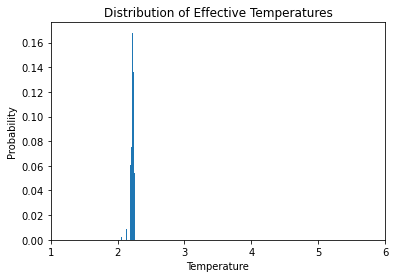

In [19]:
import matplotlib.pyplot as plt

# Convert the list of effective temperatures into a numpy array
effective_temperatures = np.array(effective_temperatures)

# Plot the histogram of effective temperatures
plt.hist(effective_temperatures, bins=30, weights=np.ones(len(effective_temperatures)) / len(effective_temperatures))
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.title('Distribution of Effective Temperatures')
plt.xlim([1, 6])  # Set the range of the x-axis to be between 1 and 6
plt.show()

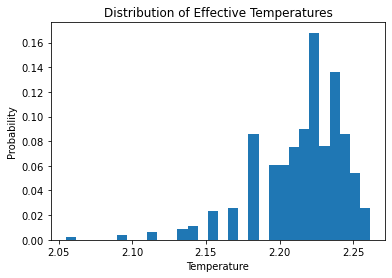

In [20]:
plt.hist(effective_temperatures, bins=30, weights=np.ones(len(effective_temperatures)) / len(effective_temperatures))
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.title('Distribution of Effective Temperatures')
plt.show()


# Testing

In [14]:
# Generate new samples

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [16]:
h = np.random.randint(0, 2, size=(num_hidden,))
for _ in range(1000):  # perform Gibbs sampling for some iterations
    probs = sigmoid(np.dot(h, rbm.weights) + rbm.visible_bias)
    v = np.random.binomial(1, probs)
    probs = sigmoid(np.dot(v, rbm.weights.T) + rbm.hidden_bias)
    h = np.random.binomial(1, probs)


In [17]:
# calculate free energy of visible state

In [18]:
def free_energy(v, rbm):
    v = v[np.newaxis]  # make sure v is a 2D array
    h = np.dot(v, rbm.weights.T) + rbm.hidden_bias
    return - np.dot(v, rbm.visible_bias.T) - np.sum(np.logaddexp(0, h))

# usage:
v = rbm_data[0]
F = free_energy(v, rbm)


In [19]:
print('Free energy of the given visible state is', F)

Free energy of the given visible state is [[-806172.84701944 -806172.84701944 -806172.84701944 ... -806172.84701944
  -806172.84701944 -806172.84701944]]


In [20]:
for i in range(len(rbm_data)):
    v = rbm_data[i]
    F = free_energy(v, rbm)
    print(f'Free energy of visible state {i} is {F}')


Free energy of visible state 0 is [[-806172.84701944 -806172.84701944 -806172.84701944 ... -806172.84701944
  -806172.84701944 -806172.84701944]]
Free energy of visible state 1 is [[-805851.72634896 -805851.71359516 -805851.72634896 ... -805851.72634896
  -805851.72593123 -805851.72634896]]
Free energy of visible state 2 is [[-745205.14615405 -745205.19342416 -745205.15397287 ... -745205.00509507
  -745205.01144165 -745204.96920436]]
Free energy of visible state 3 is [[-762487.14467481 -762487.21127481 -762487.18719045 ... -762487.16955765
  -762487.26155095 -762487.14553811]]
Free energy of visible state 4 is [[-768618.27667186 -768618.26107197 -768618.19967622 ... -768618.13040562
  -768618.28163163 -768618.22750154]]
